# Configurações iniciais

In [60]:
# LIBS
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, label_binarize
import re
import warnings 
from sklearn.base import BaseEstimator, TransformerMixin
warnings.filterwarnings('ignore') 
import seaborn as sns
import joblib

# CONFIGURAÇÕES

pd.set_option('display.max_rows',100) # Ajustando número máximo de linhas a serem exibidas por dataframes
pd.set_option('display.max_columns',100) # Ajustando número máximo de colunas a serem exibidas por dataframes
pd.set_option('display.width', 100) # Ajustando tamanho a ser exibido dos valores do dataframe
pd.set_option('display.float_format', lambda x: '%.4f' % x) # Ajustando o valor dos valores floats para 4 casas decimais
%config InlineBackend.figure_format = 'retina' # Ajustando a nitidez dos gráficos
SEED = 27 # Semente para reprodução de pseudo-aleatoriedade

# DIRETÓRIOS

project_data_path = '../data' # Diretório da base de dados
model_path = '../model' # Diretório para o modelo
src_path = '../transformers' 
sys.path.insert(0, src_path)

from transformers import CombineTextColumns, CustomImputer, FullTextPreprocessor

# Preparando a base

In [61]:
# Aqui faço a leitura da base de dados a partir da variável 'project_data_path', na pasta 'raw' e o arquivo 'Travel_Chalenge.csv'

df = pd.read_csv(os.path.join(project_data_path, 'raw', 'Travel_Chalenge.csv'), sep = ';')
df.sample(3) # Uma amostra aleatória de 3 registros dos dados

,Airline Name,Overall_Rating,Review_Title,Review Date,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity
1832,Jet Airways,1,"""rude replies from staff""",13th February 2019,Delhi from Ahmedabad with one hour Stop in M...,NaN,Solo Leisure,Economy Class,Ahmedabad to Delhi via Mumbai,February 2019,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6687,Sun Country Airlines,3,"""I will be reconsidering book with them going ...",20th January 2022,Boarded 10 minutes late. Sat on the plane fo...,Boeing 737,Couple Leisure,Economy Class,Minneapolis to Tampa,January 2022,2.0000,4.0000,3.0000,1.0000,NaN,NaN
7926,Icelandair,2,"""Flight attendants were not friendly""",22nd July 2022,They don’t offer any food for flights that a...,NaN,Solo Leisure,Economy Class,Toronto to Frankfurt via Keflavik,January 2022,1.0000,1.0000,NaN,1.0000,1.0000,NaN


## Variável Target

In [62]:
# Tratando variável de interesse
df.loc[df['Overall_Rating'] == 'n', 'Overall_Rating'] = int(df.loc[df['Overall_Rating'] != 'n', 'Overall_Rating'].astype(int).median())
df['Overall_Rating'] = df['Overall_Rating'].astype(int)

In [63]:
# Criando classe de sentimentos para modelagem

def rules(rating):
    if rating < 4:
        return 'negative'
    elif rating >= 4 and rating <= 7:
        return 'neutral'
    else:
        return 'positive'
    
def encode_rules(class_col):
    if class_col == 'negative':
        return 0
    elif class_col == 'neutral':
        return 1
    elif class_col == 'positive':
        return 2


df.insert(2, 'Status', df['Overall_Rating'].apply(rules))
df.insert(3, 'Class', df['Status'].apply(encode_rules))

df.sample(3)

,Airline Name,Overall_Rating,Status,Class,Review_Title,Review Date,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity
6392,QantasLink,9,positive,2,"""pleasure flying with QantasLink""",1st October 2015,Travelled QantasLink from Brisbane to Townsvil...,Boeing 717 / Dash 8 Q400,Solo Leisure,Economy Class,BNE to TSV via MKY,October 2015,4.0000,4.0000,4.0000,4.0000,NaN,NaN
14180,ITA Airways,1,negative,0,"""the worst airline ever!",3rd May 2023,By far the worst airline ever. They changed ...,NaN,Family Leisure,Economy Class,Amsterdam to Palermo,April 2023,1.0000,1.0000,1.0000,1.0000,NaN,NaN
12157,Jetstar Pacific,5,neutral,1,Jetstar Pacific customer review,29th October 2012,SIN-SGN. Price was excellent. Check-in and boa...,NaN,NaN,Economy Class,NaN,NaN,3.0000,2.0000,4.0000,NaN,1.0000,NaN


In [64]:
df['Class'].value_counts() # Variável de interesse desbalanceada

Class
0    12622
2     2545
1     2535
Name: count, dtype: int64

## Colunas de texto

In [65]:
def clean_text(text):
    # Converte o texto para minúsculas
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove menções (@username)
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove pontuações e caracteres especiais (exceto espaços)
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove números
    text = re.sub(r'\d+', '', text)
    
    # Remove múltiplos espaços em branco
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


# Removendo stopwords utilizando o idioma Inglês
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return ' '.join([word for word in text.split() if word not in stop_words])


# Redução de palavras usando lemmatização
def apply_lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

# Removendo emojis
def remove_emojis(text):
    return text.encode('ascii', 'ignore').decode('ascii')

# Considerando que a palavra 'not' pode inverter o sentido 
# Como por exemplo: "I absolutely loooove this product! It's not bad at all 😊",
# Nos casos de uso da palavra 'not', a função marca a próxima palavra e junta como uma única expressão, 
# Exemplo: 'not good' => 'not_good' 

def handle_negation(text):
    negation = "not"
    words = text.split()
    negated_sentence = []
    negate = False
    
    for word in words:
        if word == negation:
            negate = True
        elif negate:
            negated_sentence.append(f"not_{word}")
            negate = False
        else:
            negated_sentence.append(word)
    
    return ' '.join(negated_sentence)


def preprocess_text(text):
    text = handle_negation(text)
    text = clean_text(text)
    text = remove_stopwords(text)
    text = apply_lemmatization(text)
    return text


In [66]:
df.insert(7, 'Review_processed', df['Review'].apply(preprocess_text)) # Adicionando coluna de Review processada
df.insert(5, 'Review_Title_processed', df['Review_Title'].apply(preprocess_text)) # Adicionando coluna de Título da Review processada
df = df[(df['Review_Title_processed'] != '') & (df['Review_processed'] != '')] # Retirando inconsistências
df.sample(3)

,Airline Name,Overall_Rating,Status,Class,Review_Title,Review_Title_processed,Review Date,Review,Review_processed,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity
12079,Air Dolomiti,7,neutral,1,"""The crew was very professional""",crew professional,29th May 2022,LH2371 from ZRH to MUC operated by Air Dolomi...,lh zrh muc operated air dolomiti flight delay ...,E195,Solo Leisure,Economy Class,Zurich to Munich,May 2022,3.0000,5.0000,NaN,4.0000,NaN,NaN
17328,FlySafair,3,negative,0,"""I had to give up my bag""",give bag,9th January 2018,"I sat in Seat 3E, which is right behind the e...",sat seat e right behind exit row seat consider...,NaN,Couple Leisure,Economy Class,George to Johannesburg,January 2018,1.0000,1.0000,NaN,3.0000,NaN,NaN
3504,CSA Czech Airlines,3,negative,0,"""my seat was dirty""",seat dirty,16th December 2018,Madrid to Odessa via Prague. Disappointed. On...,madrid odessa via prague disappointed first fl...,A321 / 319,Solo Leisure,Economy Class,Madrid to Odessa via Prague,June 2018,4.0000,2.0000,5.0000,1.0000,2.0000,NaN


In [67]:
# Adicionando "string coringa" para valores inválidos

df.loc[df['Aircraft'].isna(), 'Aircraft'] = 'No Info'
df.loc[df['Type Of Traveller'].isna(), 'Type Of Traveller'] = 'No Info'
df.loc[df['Seat Type'].isna(), 'Seat Type'] = 'No Info'
df.loc[df['Route'].isna(), 'Route'] = 'No Info'

In [68]:
df = df[~df.duplicated()] # Retirando duplicadas

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17672 entries, 0 to 17701
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Airline Name            17672 non-null  object 
 1   Overall_Rating          17672 non-null  int64  
 2   Status                  17672 non-null  object 
 3   Class                   17672 non-null  int64  
 4   Review_Title            17672 non-null  object 
 5   Review_Title_processed  17672 non-null  object 
 6   Review Date             17672 non-null  object 
 7   Review                  17672 non-null  object 
 8   Review_processed        17672 non-null  object 
 9   Aircraft                17672 non-null  object 
 10  Type Of Traveller       17672 non-null  object 
 11  Seat Type               17672 non-null  object 
 12  Route                   17672 non-null  object 
 13  Date Flown              15943 non-null  object 
 14  Seat Comfort            15455 non-null  flo

# Início da modelagem

## Modelo 1

Como primeiro modelo, usarei a abordagem de utilizar apenas as colunas de texto referentes as Reviews como classificador dos sentimentos.

In [70]:
X = df[['Review_processed', 'Review_Title_processed']].copy()
X.columns = ['Review', 'Review_Title']
y = df['Class']

In [71]:
# Dividindo base entre treino e teste
# shuffle = True: Embaralha os dados durante a divisão
# stratify = y: Mantém as proporções da variável de interesse, no caso 'y'

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, shuffle = True, stratify = y, random_state = SEED) 

In [72]:
X_train.sample(5)

,Review,Review_Title
12840,xian kuala lumpur overnight hr flight purchase...,wouldnt recommend
8524,left laptop plane darlene southwest baggage cl...,worst customer service
5966,due high wind manchester plane diverted east m...,absolutely communication
13878,southend catania mile destination pilot announ...,never trust air malta
443,flew auckland papeete flight hour long seated ...,air tahiti nui customer review


In [73]:
y_train.sample(5)

10463    1
13568    1
7110     0
484      1
13091    2
Name: Class, dtype: int64

In [74]:
print("Tamanho de X_train:", len(X_train))
print("Tamanho de y_train:", len(y_train))
print("Tamanho de X_test:", len(X_test))
print("Tamanho de y_test:", len(y_test))

Tamanho de X_train: 12370
Tamanho de y_train: 12370
Tamanho de X_test: 5302
Tamanho de y_test: 5302


In [75]:
print(X_train.shape,y_train.shape)

(12370, 2) (12370,)


### Otimizando hiperparâmetros

Para otimizar os hiperparâmetros do modelo, utilizarei o método ``RandomizedSearchCV`` de forma aninhada.
A função ``randomizedsearch`` realiza uma busca aleatória de hiperparâmetros usando ``RandomizedSearchCV`` e avalia o desempenho do melhor modelo encontrado por meio da validação cruzada.

- ``StratifiedKFold``: Utilizado para dividir os dados em folds de maneira estratificada, preservando a proporção das classes (y).

- Já a validação cruzada externa é um método utilizado para avaliar o desempenho de um modelo de forma robusta e não tendenciosa, com objetivo de fornecer uma estimativa mais realista do desempenho do modelo quando aplicado a novos dados.

#### RandomizedSearchCV

In [76]:
# Função que realiza o RandomizedSearchCV para otimização de hiperparâmetros

def randomizedsearch(model, param_grid,  Xtrain, Ytrain, seed = SEED):
    icv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)
    ocv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)

    rs = RandomizedSearchCV(
        estimator = model, 
        param_distributions = param_grid, 
        scoring = 'accuracy', # métrica de avaliação
        # n_jobs = -1, 
        cv = icv 
    )

    rs_scores = cross_val_score(rs, Xtrain, Ytrain, cv = ocv)
    print(f'resultado de cada iteração do cv externo: {rs_scores}')
    print(f'média: {rs_scores.mean()}')

    return rs

In [77]:
param_grid = [
    {'Clf__solver' : ['newton-cg', 'lbfgs'],
      'Clf__penalty' : ['l2'],
      'Clf__max_iter' : np.linspace(100, 500, 5, dtype=int),
      'Clf__C' : [0.001, 0.01, 0.1, 1, 10, 30]},
    {'Clf__solver' : ['liblinear'],
      'Clf__penalty' : ['l1', 'l2'],
      'Clf__max_iter' : np.linspace(100, 500, 5, dtype=int),
      'Clf__C' : [0.001, 0.01, 0.1, 1, 10, 30]},
]

In [78]:
pipeline1 = Pipeline([
    ('JoinText', CombineTextColumns(col1 = 'Review_Title', col2 = 'Review')), # Transformer para combinar colunas de texto.
    ('Processor', FullTextPreprocessor()),
    ('Tfidf', TfidfVectorizer(lowercase = True, max_features = 50)), # Converte o texto em uma matriz TF-IDF
    ('Clf', LogisticRegression()) # Modelo de classificação (Logistic Regression)
])

In [79]:
rs_mod1 = randomizedsearch(pipeline1, param_grid, X_train, y_train)

resultado de cada iteração do cv externo: [0.74090542 0.72271625 0.74090542 0.72716249 0.73403395]
média: 0.7331447049312854


In [80]:
rs_mod1

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=27, shuffle=True),
                   estimator=Pipeline(steps=[('JoinText', CombineTextColumns()),
                                             ('Processor',
                                              FullTextPreprocessor()),
                                             ('Tfidf',
                                              TfidfVectorizer(max_features=50)),
                                             ('Clf', LogisticRegression())]),
                   param_distributions=[{'Clf__C': [0.001, 0.01, 0.1, 1, 10,
                                                    30],
                                         'Clf__max_iter': array([100, 200, 300, 400, 500]),
                                         'Clf__penalty': ['l2'],
                                         'Clf__solver': ['newton-cg', 'lbfgs']},
                                        {'Clf__C': [0.001, 0.01, 0.1, 1, 10,
                                                    30],
                                         'Clf__max_iter': array([100, 200, 300, 400, 500]),
                                         'Clf__penalty': ['l1', 'l2'],
                                         'Clf__solver': ['liblinear']}],
                   scoring='accuracy')

In [81]:
rs_mod1.fit(X_train, y_train) # Ajustando os dados para obter os melhores hiperparâmetros segundo o RandomizedSearchCV

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=27, shuffle=True),
                   estimator=Pipeline(steps=[('JoinText', CombineTextColumns()),
                                             ('Processor',
                                              FullTextPreprocessor()),
                                             ('Tfidf',
                                              TfidfVectorizer(max_features=50)),
                                             ('Clf', LogisticRegression())]),
                   param_distributions=[{'Clf__C': [0.001, 0.01, 0.1, 1, 10,
                                                    30],
                                         'Clf__max_iter': array([100, 200, 300, 400, 500]),
                                         'Clf__penalty': ['l2'],
                                         'Clf__solver': ['newton-cg', 'lbfgs']},
                                        {'Clf__C': [0.001, 0.01, 0.1, 1, 10,
                                                    30],
                                         'Clf__max_iter': array([100, 200, 300, 400, 500]),
                                         'Clf__penalty': ['l1', 'l2'],
                                         'Clf__solver': ['liblinear']}],
                   scoring='accuracy')

In [82]:
rs_mod1.best_params_

{'Clf__solver': 'lbfgs',
 'Clf__penalty': 'l2',
 'Clf__max_iter': np.int64(100),
 'Clf__C': 10}

In [83]:
mod1_best_params = {key.split('__')[1]: value for key, value in rs_mod1.best_params_.items()}
mod1_best_params

{'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': np.int64(100), 'C': 10}

In [84]:
# Avaliando classificador em base de teste

opt_mod1 = Pipeline([
    ('JoinText', CombineTextColumns(col1 = 'Review_Title', col2 = 'Review')),
    ('Processor', FullTextPreprocessor()),
    ('Tfidf', TfidfVectorizer(lowercase = True, max_features = 50)),          
    ('Clf', LogisticRegression(**mod1_best_params))          
])

opt_mod1.fit(X_train, y_train)
mod1_predict = opt_mod1.predict(X_test)

report = classification_report(y_test, mod1_predict)
print(report)

              precision    recall  f1-score   support

           0       0.78      0.95      0.86      3778
           1       0.46      0.07      0.12       760
           2       0.48      0.40      0.43       764

    accuracy                           0.74      5302
   macro avg       0.57      0.47      0.47      5302
weighted avg       0.69      0.74      0.69      5302



In [99]:
X_test

,Review,Review_Title
16448,bengaluru chennai made wait half hour baggage ...,staff inefficient
3651,amsterdam prague departure delayed hour inform...,temperature unpleasantly high
2823,flew lao airline bangkok savannakhet prompt ch...,service onboard friendly
15739,purchased roundtrip ticket vacation month adva...,furious lack respect
7824,flew aerolineas buenos aire iguazu one dysfunc...,one dysfunctional organisation
...,...,...
13997,excellent crew leg food satisfactory airline m...,airline management equipment poor
3459,saint louis reykjavik first book wow premium t...,bumped two class
14273,flight service started well staff warm interac...,one best luggage allowance
6768,comfortable seat plenty legroom fast boarding ...,comfortable seat plenty legroom


## Modelo 2

In [85]:
X2 = df.iloc[:, 14:]
y2 = df['Class']

In [86]:
X2.isnull().sum()

Seat Comfort               2217
Cabin Staff Service        2307
Food & Beverages           5748
Ground Service             2617
Inflight Entertainment     8441
Wifi & Connectivity       12429
dtype: int64

In [87]:
X2[X2.isna()]

,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
17697,NaN,NaN,NaN,NaN,NaN,NaN
17698,NaN,NaN,NaN,NaN,NaN,NaN
17699,NaN,NaN,NaN,NaN,NaN,NaN
17700,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2, test_size = 0.3, shuffle = True, stratify = y, random_state = SEED) 

### Otimizando hiperparâmetros

#### RandomizedSearchCV

In [89]:
param_grid = [
    {'Clf__solver' : ['newton-cg', 'lbfgs'],
      'Clf__penalty' : ['l2'],
      'Clf__max_iter' : np.linspace(100, 500, 5, dtype=int),
      'Clf__C' : [0.001, 0.01, 0.1, 1, 10, 30]},
    {'Clf__solver' : ['liblinear'],
      'Clf__penalty' : ['l1', 'l2'],
      'Clf__max_iter' : np.linspace(100, 500, 5, dtype=int),
      'Clf__C' : [0.001, 0.01, 0.1, 1, 10, 30]},
]

In [90]:
## PIPELINE 2

pipeline2 = Pipeline([
    ('Inputer', CustomImputer()),
    ('Processor', StandardScaler()),
    ('Clf', LogisticRegression())
])

pipeline2.fit(X_train2, y_train2)
pipeline2_predict = pipeline2.predict(X_test2)

In [91]:
rs_mod2 = randomizedsearch(pipeline2, param_grid, X_train2, y_train2)

resultado de cada iteração do cv externo: [0.69846403 0.7174616  0.69927243 0.71827001 0.70169766]
média: 0.7070331447049313


In [92]:
rs_mod2.fit(X_train2, y_train2)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=27, shuffle=True),
                   estimator=Pipeline(steps=[('Inputer', CustomImputer()),
                                             ('Processor', StandardScaler()),
                                             ('Clf', LogisticRegression())]),
                   param_distributions=[{'Clf__C': [0.001, 0.01, 0.1, 1, 10,
                                                    30],
                                         'Clf__max_iter': array([100, 200, 300, 400, 500]),
                                         'Clf__penalty': ['l2'],
                                         'Clf__solver': ['newton-cg', 'lbfgs']},
                                        {'Clf__C': [0.001, 0.01, 0.1, 1, 10,
                                                    30],
                                         'Clf__max_iter': array([100, 200, 300, 400, 500]),
                                         'Clf__penalty': ['l1', 'l2'],
                                         'Clf__solver': ['liblinear']}],
                   scoring='accuracy')

In [93]:
rs_mod2.best_params_

{'Clf__solver': 'liblinear',
 'Clf__penalty': 'l2',
 'Clf__max_iter': np.int64(300),
 'Clf__C': 0.001}

In [94]:
mod2_best_params = {key.split('__')[1]: value for key, value in rs_mod2.best_params_.items()}
mod2_best_params

{'solver': 'liblinear', 'penalty': 'l2', 'max_iter': np.int64(300), 'C': 0.001}

In [95]:
opt_mod2 = pipeline2 = Pipeline([
    ('Inputer', CustomImputer()),
    ('Processor', StandardScaler()),
    ('Clf', LogisticRegression(**mod2_best_params))           
])

opt_mod2.fit(X_train2, y_train2)
mod2_predict = opt_mod2.predict(X_test2)

report2 = classification_report(y_test2, mod2_predict)
print(report2)

              precision    recall  f1-score   support

           0       0.77      0.88      0.82      3778
           1       0.00      0.00      0.00       760
           2       0.46      0.58      0.51       764

    accuracy                           0.71      5302
   macro avg       0.41      0.49      0.44      5302
weighted avg       0.61      0.71      0.66      5302



# Comparando modelos

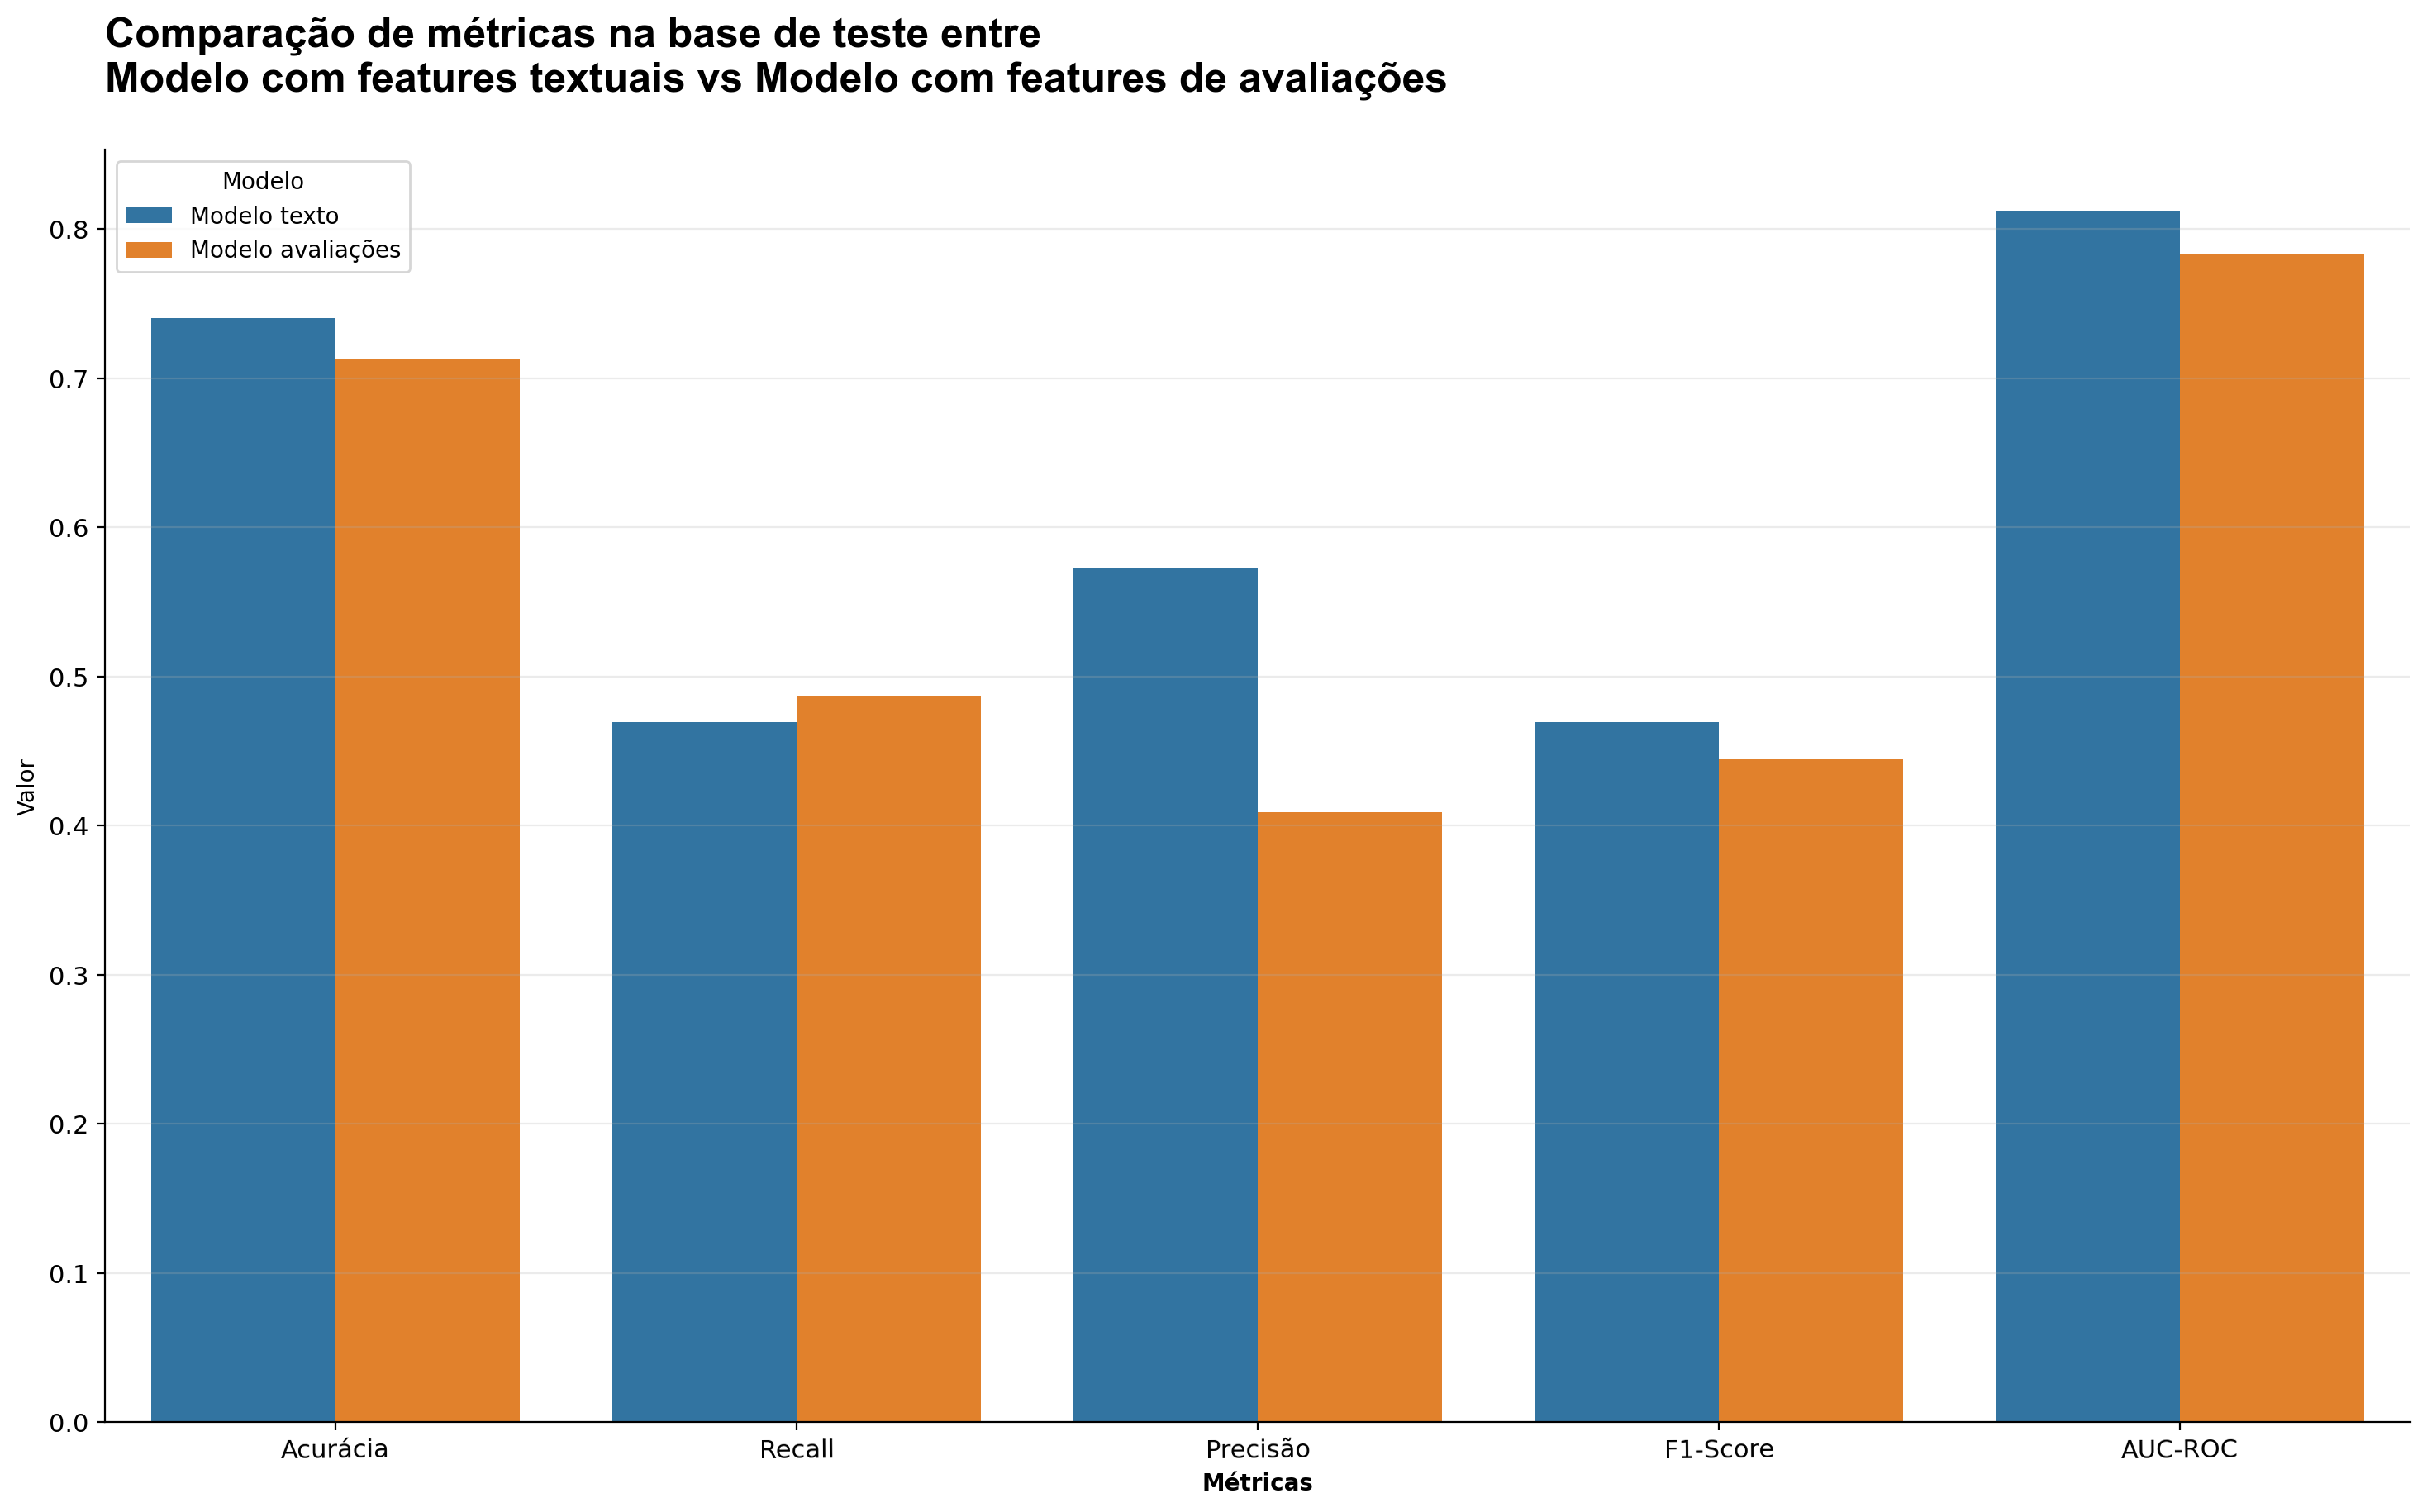

In [96]:
# Previsões
y_pred1 = mod1_predict
y_pred2 = mod2_predict

# Acurácia
accuracy1 = accuracy_score(y_test, y_pred1)
accuracy2 = accuracy_score(y_test2, y_pred2)

# Recall
recall1 = recall_score(y_test, y_pred1, average='macro')
recall2 = recall_score(y_test, y_pred2, average='macro')

# Precisão
precision1 = precision_score(y_test, y_pred1, average='macro')
precision2 = precision_score(y_test2, y_pred2, average='macro')

# F1-Score (macro)
f1_1 = f1_score(y_test, y_pred1, average='macro')
f1_2 = f1_score(y_test2, y_pred2, average='macro')

# Para calcular o AUC-ROC para múltiplas classes, binarizar as labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_test_bin2 = label_binarize(y_test2, classes=[0, 1, 2])

# Prever probabilidades para o AUC-ROC
y_prob1 = opt_mod1.predict_proba(X_test)
y_prob2 = opt_mod2.predict_proba(X_test2)

# AUC-ROC
auc_roc1 = roc_auc_score(y_test_bin, y_prob1, average='macro', multi_class='ovo')
auc_roc2 = roc_auc_score(y_test_bin2, y_prob2, average='macro', multi_class='ovo')

# Colocar as métricas em um dicionário para plotar
metrics = {
    'Métrica': ['Acurácia', 'Recall', 'Precisão', 'F1-Score', 'AUC-ROC', 'Acurácia', 'Recall', 'Precisão', 'F1-Score', 'AUC-ROC'],
    'Valor': [accuracy1, recall1, precision1, f1_1, auc_roc1, accuracy2, recall2, precision2, f1_2, auc_roc2],
    'Modelo': ['Modelo texto'] * 5 + ['Modelo avaliações'] * 5
}

# Convertendo dicionário de métricas em DataFrame para visualização
metrics_df = pd.DataFrame(metrics)

# Plotando as métricas
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(x='Métrica', y='Valor', hue='Modelo', data=metrics_df, palette=['#1f77b4', '#ff7f0e'], ax = ax)
ax.set_title('Comparação de métricas na base de teste entre\nModelo com features textuais vs Modelo com features de avaliações\n', loc = 'left', fontsize = 18, fontfamily = 'arial', fontweight = 'bold')
ax.set_ylabel('Valor')
ax.set_xlabel('Métricas', fontweight = 'bold')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(True, axis = 'y', alpha = .25)
ax.xaxis.set_tick_params(labelsize = 11, labelrotation = .5)
ax.yaxis.set_tick_params(labelsize = 11)

O gráfico acima deixa claro que **o modelo que usou as informações textuais de** ``Review`` **e** ``Review_Title`` **conseguiu um melhor desempenho com os dados de teste em todas as métricas de avaliação**.  
E portanto, é o melhor modelo para classificação de sentimentos com os dados trabalhados.

In [97]:
# Exportando melhor modelo
joblib.dump(opt_mod1, os.path.join(model_path, 'model.pkl'))

['../model\\model.pkl']